# Deep Neural Network for Image Classification

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage


2 - Load and Process the Dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving test_catvnoncat.h5 to test_catvnoncat.h5
Saving train_catvnoncat.h5 to train_catvnoncat.h5


In [3]:
from PIL import Image
import h5py
from scipy import ndimage

def load_data():

    with h5py.File('train_catvnoncat.h5', 'r') as train_data:
    # Access specific datasets within the HDF5 file
    # For example, if 'train_set_x' and 'train_set_y' are datasets:
      train_x_orig = np.array(train_data['train_set_x'][:])
      train_y = np.array(train_data['train_set_y'][:])

# Use h5py.File to open and read the HDF5 file for test data
    with h5py.File('test_catvnoncat.h5', 'r') as test_data:
    # Access the data within the HDF5 file
    # Assuming 'test_set_x', 'test_set_y', and 'classes' are datasets:
       test_x_orig = np.array(test_data['test_set_x'][:])
       test_y = np.array(test_data['test_set_y'][:])
       classes = np.array(test_data['list_classes'][:])

    return train_x_orig, train_y, test_x_orig, test_y, classes

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


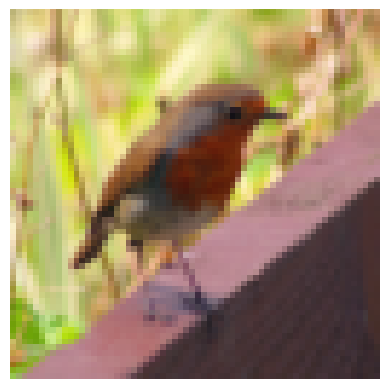

In [5]:
# Example of a picture

train_y = train_y.flatten()  # Ensures train_y is a 1D array
index = 10
plt.imshow(train_x_orig[index])
plt.axis('off')
print("y = " + str(train_y[index]) +
      ". It's a " + classes[train_y[index]].decode("utf-8") + " picture.")


y = 1. It's a cat picture.


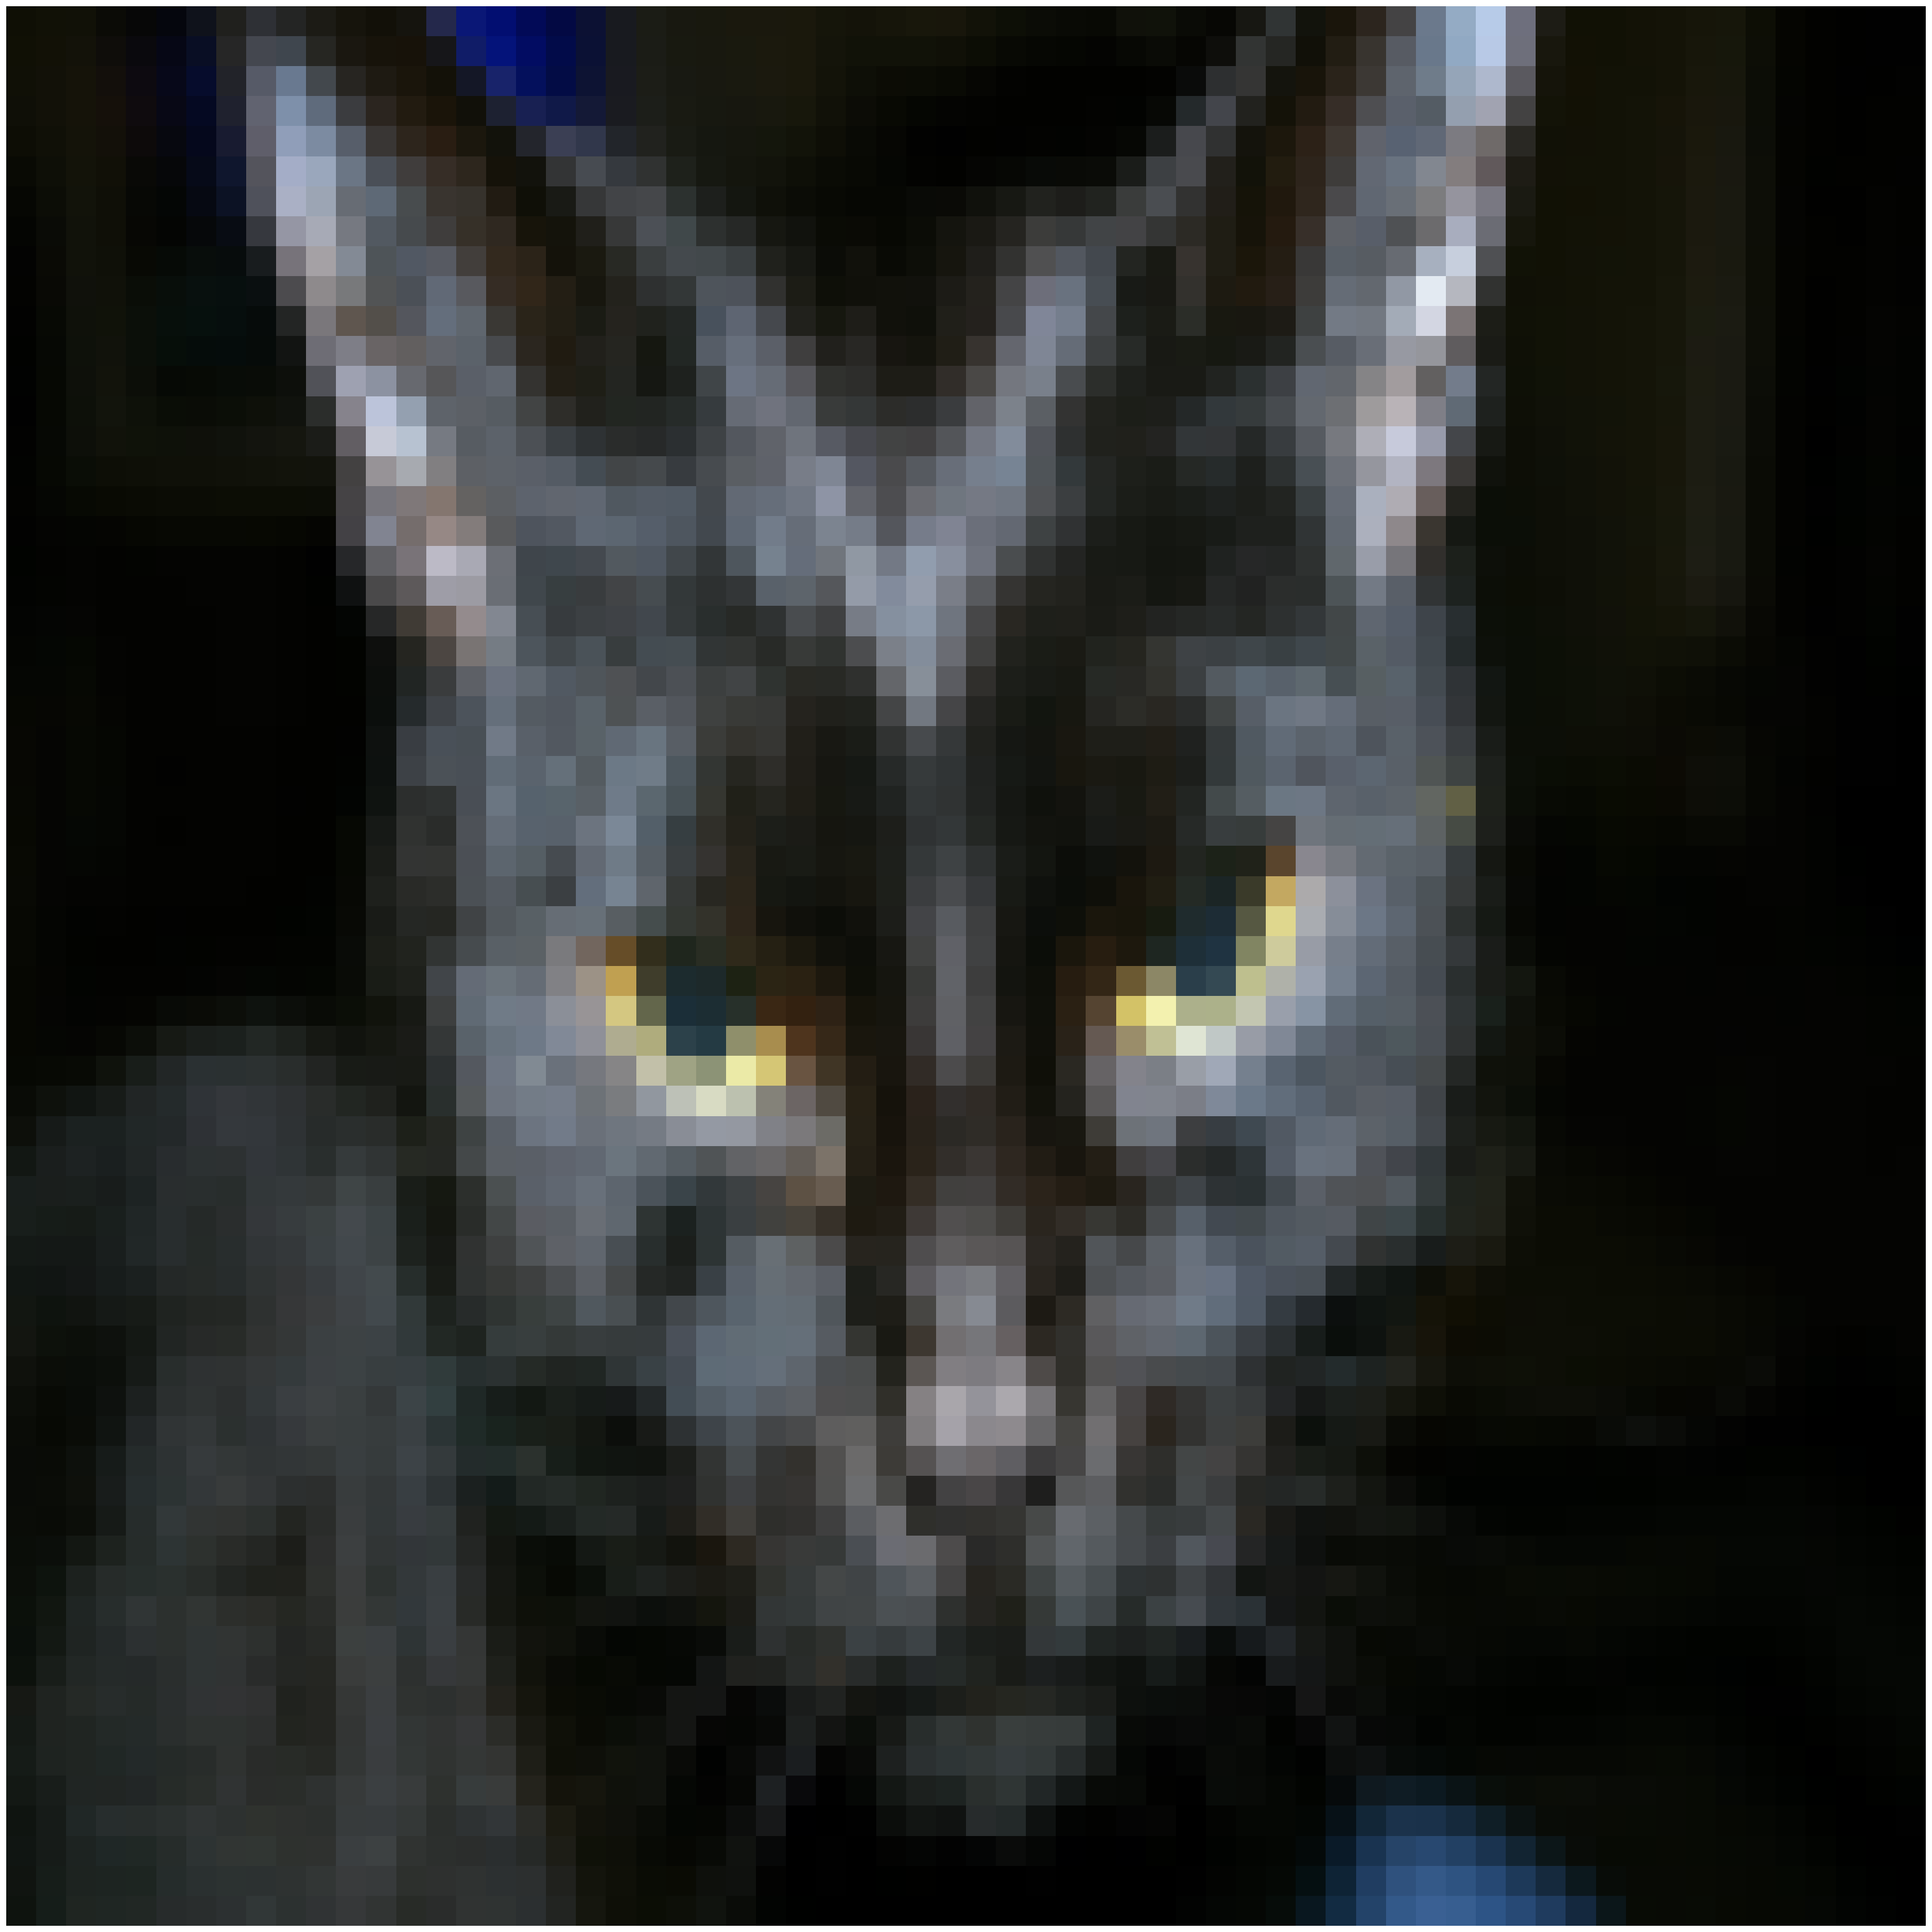

In [74]:
# Example of a picture

train_y = train_y.flatten()  # Ensures train_y is a 1D array
index = 25
plt.imshow(train_x_orig[index])
plt.axis('off')
print("y = " + str(train_y[index]) +
      ". It's a " + classes[train_y[index]].decode("utf-8") + " picture.")


In [6]:
## Explore the datset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training example: "+ str(m_train))
print ("Number of testing example: "+ str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))


Number of training example: 209
Number of testing example: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (209,)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (50,)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

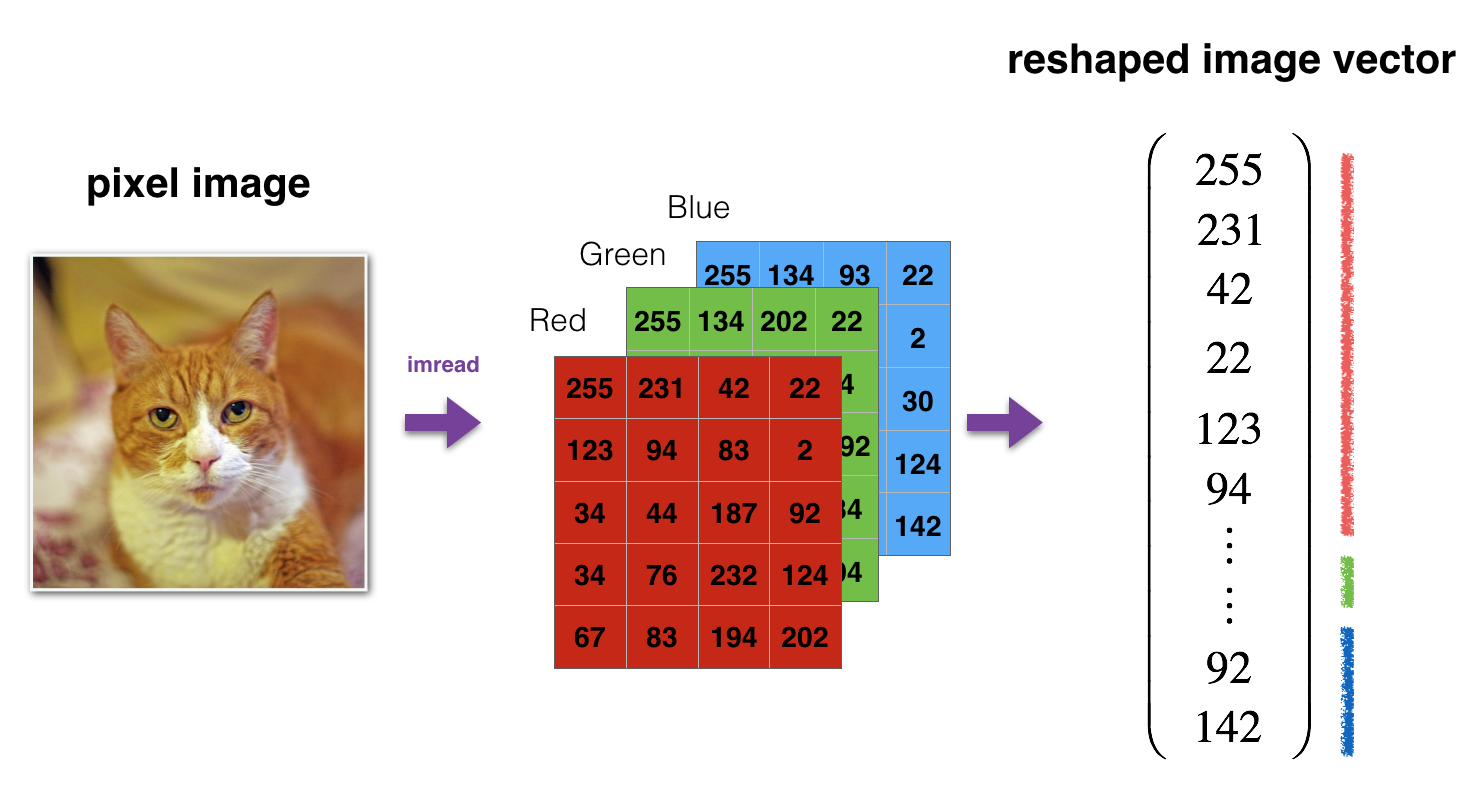


Figure 1: Image to vector conversion.

In [7]:
# Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

In [8]:
# Standardize data to have feature value between 0 and 1
train_x = train_x_flatten/255
test_x = test_x_flatten/255

print("train_x's shape: "+ str(train_x.shape))
print("test_x's shape: "+ str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


# Model architecture

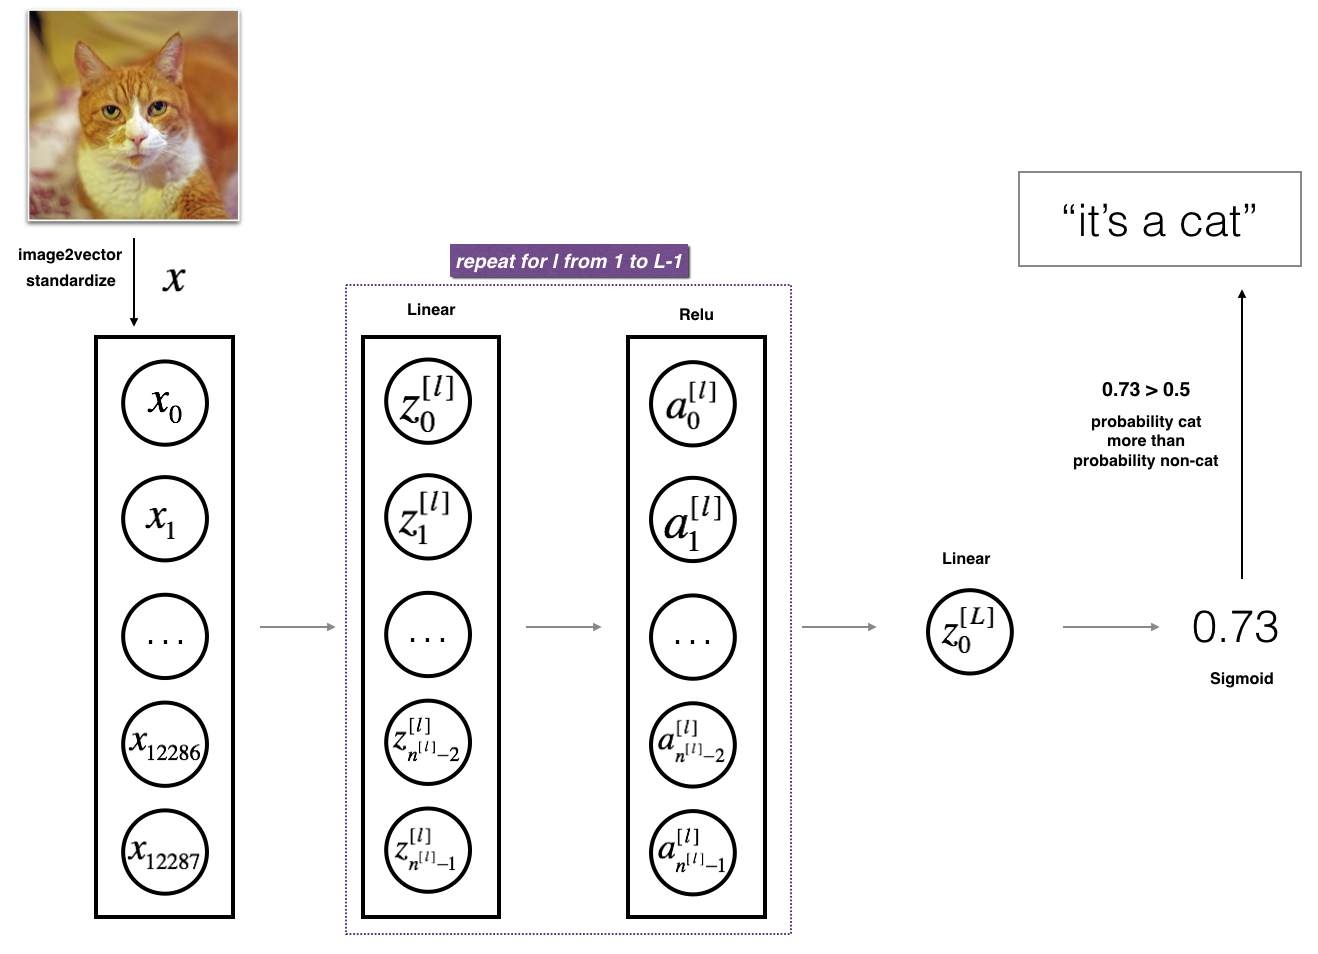

 **General Methodology**

As usual, you'll follow the Deep Learning methodology to build the model:

(i) Initialize parameters / Define hyperparameters.

(ii) Loop for num_iterations: a. Forward propagation b. Compute cost function c. Backward propagation d. Update parameters (using parameters, and grads from backprop).

(iii) Use trained parameters to predict labels
Now go ahead and implement those two models!

In [ ]:
### two layer Neural network

In [9]:
## Constrain defining the model
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [38]:
def initialize_parameters(n_x, n_h, n_y):

    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters


In [39]:
def linear_activation_forward(A_prev, W, b, activation):

    Z = np.dot(W, A_prev) + b

    if activation == "relu":
        A = np.maximum(0, Z)
    elif activation == "sigmoid":
        A = 1 / (1 + np.exp(-Z))
    else:
        raise ValueError("Invalid activation function")

    cache = (A_prev, W, b, Z)
    return A, cache


In [45]:
def compute_cost(AL, Y):

    # Reshape Y if it's 1D
    if Y.ndim == 1:
        Y = Y.reshape(1, -1)  # Reshape to (1, number of examples)

    m = Y.shape[1]
    cost = -np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL)) / m
    cost = np.squeeze(cost)  # Ensures cost is a scalar
    return cost

In [46]:
def linear_activation_backward(dA, cache, activation):

    A_prev, W, b, Z = cache
    m = A_prev.shape[1]

    if activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    elif activation == "sigmoid":
        s = 1 / (1 + np.exp(-Z))
        dZ = dA * s * (1 - s)
    else:
        raise ValueError("Invalid activation function")

    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


In [47]:
def update_parameters(parameters, grads, learning_rate):

    parameters["W1"] -= learning_rate * grads["dW1"]
    parameters["b1"] -= learning_rate * grads["db1"]
    parameters["W2"] -= learning_rate * grads["dW2"]
    parameters["b2"] -= learning_rate * grads["db2"]

    return parameters


In [48]:
# Two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims

    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###

    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".

        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")

        # Compute cost

        cost = compute_cost(A2, Y)


        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".

        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")


        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

# Train The model

Cost after iteration 0: 0.6930497356599891
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.30527536361962637
Cost after iteration 1200: 0.27491377282130164
Cost after iteration 1300: 0.24681768210614843
Cost after iteration 1400: 0.19850735037466105
Cost after iteration 1500: 0.17448318112556643
Cost after iteration 1600: 0.17080762978096395
Cost after iteration 1700: 0.1130652456216472
Cost after iteration 1800: 0.09629426845937153
Cost after iteration 1900: 0.08342617959726865
Cost after iteration 2000: 0.07439078704319083
Cost after iteration 2100: 0.066307481

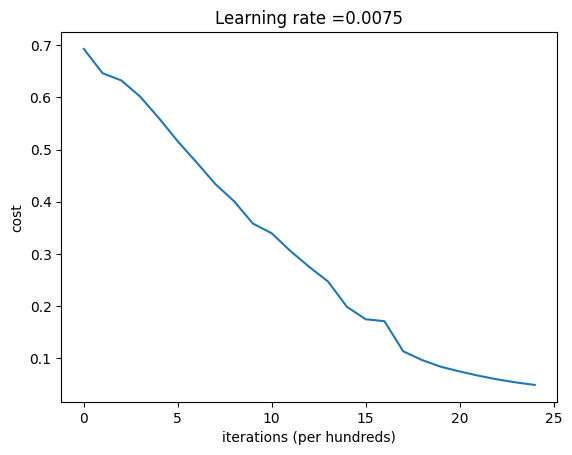

In [49]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [61]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2  # Number of layers in the neural network

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        A, cache = linear_activation_forward(A_prev, W, b, activation="relu")
        caches.append(cache)

    # Implement LINEAR -> SIGMOID for the last layer. Add "cache" to the "caches" list.
    W = parameters[f"W{L}"]
    b = parameters[f"b{L}"]
    AL, cache = linear_activation_forward(A, W, b, activation="sigmoid")
    caches.append(cache)

    return AL, caches


In [62]:
def predict(X, y, parameters):

    m = X.shape[1]
    n = len(parameters) // 2  # Number of layers in the neural network
    predictions = np.zeros((1, m))

    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # Convert probas to 0/1 predictions
    predictions = (probas > 0.5)

    # Print accuracy
    print("Accuracy: " + str(np.sum((predictions == y) / m)))

    return predictions


In [63]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [64]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


In [79]:
def print_mislabeled_images(classes, X, y, p):

    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (90.0, 90.0)
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]

        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:, index].reshape(num_px, num_px, 3))
        plt.axis('off')
        plt.title(
            "Prediction: " + classes[int(p[0, index])].decode("utf-8") +
            " \n Class: " + classes[y[index]].decode("utf-8"))


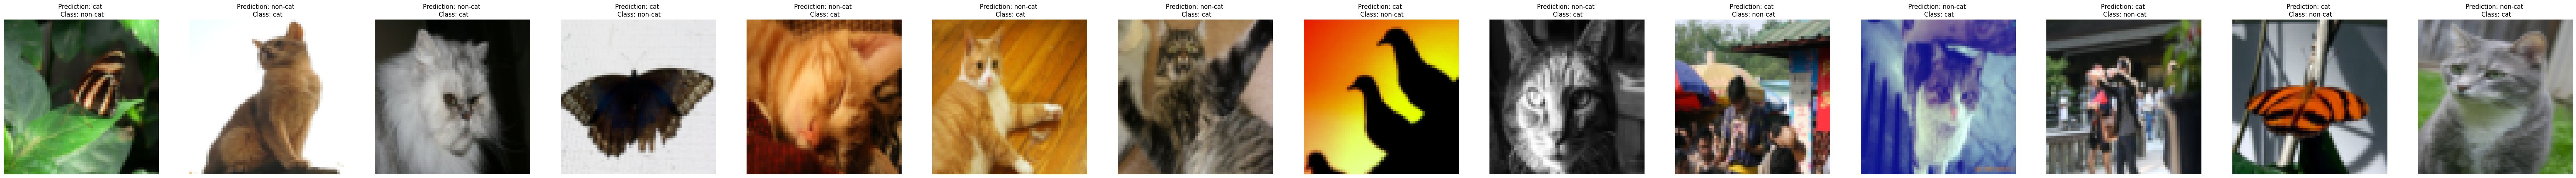

In [80]:
print_mislabeled_images(classes, test_x, test_y, predictions_test)

## L_Layer Neural Network

To increase the **accuracy**

By creating 4 layer Neural Network You can achieve *80* percent accuracy